In [73]:
import random, math

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [74]:
#  Parameters of the algorithm. Feel free to play with these and see how they affect the training!
ROUNDS = 10
DEVICES = 100
PERCENTAGE_OF_DEVICES_PER_ROUND = 0.1

First we will load the MNIST data set and split it into seperate datasets per device

In [75]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Shard the data into different devices
def shard_data(x, y, num_clients=10):
    client_names = [f"client_{i+1}" for i in range(num_clients)]
    
    data = list(zip(x, y))
    
    size = len(data)//num_clients
    
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]
    
    return {client_names[i] : shards[i] for i in range(len(client_names))} 

shards = shard_data(x_train, y_train, DEVICES)

Here we define some utility functions to create the model, and average its weights

In [76]:
# Define training parameters
lr = 0.01
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy()
metrics = ['accuracy']

def create_model():
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10),
      tf.keras.layers.Softmax(),
    ])
    model.compile(optimizer=optimizer, metrics=metrics, loss=loss_fn)
    return model

def average_weights(collected_client_data):
    total_count = sum([c[1] for c in collected_client_data])
    
    averaged_weights = []
    for layer in range(len(collected_client_data[0][0])):
        layer_weights = np.zeros(collected_client_data[0][0][layer].shape)
        for i in range(len(collected_client_data)):
            factor = collected_client_data[i][1] / total_count
            layer_weights += factor * collected_client_data[i][0][layer]
        averaged_weights.append(layer_weights)
    return averaged_weights

Then, we train the model for some rounds, keeping track of the accuracy after each round

In [77]:
global_model = create_model()

accuracy_per_round = []

for r in range(ROUNDS):
    global_weights = global_model.get_weights()
    
    # Select a random subset of the devices
    shard_keys = list(shards.keys())
    np.random.shuffle(shard_keys)
    num_devices_in_round = max(1, math.ceil(PERCENTAGE_OF_DEVICES_PER_ROUND * len(shard_keys)))
    selected_keys = shard_keys[:num_devices_in_round]
    
    collected_client_data = []
    # Train the model on each device seperately, "send" the results back to the server
    for key in selected_keys:
        data = shards[key]
        
        # Local training data
        x_train = np.array([data[i][0] for i in range(len(data))])
        y_train = np.array([data[i][1] for i in range(len(data))])
        
        # set up local model
        local_model = create_model()
        local_model.set_weights(global_weights)
        local_model.fit(x_train, y_train, verbose=0)
        
        collected_client_data.append((local_model.get_weights(), len(data)))
    
    # Average the weights we have "received" from the clients and update the global model
    averaged_weights = average_weights(collected_client_data)
    global_model.set_weights(averaged_weights)
    
    # Evaluate the global model after this round and save the accuracy for later
    global_metrics = global_model.evaluate(x_test,  y_test, verbose=0)
    print(f"Evaluating model after round {r+1} - Accuracy: {100*global_metrics[1]:.2f}% - Loss: {global_metrics[0]:.4f}")
    accuracy_per_round.append(global_metrics[1])

Evaluating model after round 1 - Accuracy: 84.87% - Loss: 0.5712
Evaluating model after round 2 - Accuracy: 88.86% - Loss: 0.3719
Evaluating model after round 3 - Accuracy: 91.30% - Loss: 0.2939
Evaluating model after round 4 - Accuracy: 91.67% - Loss: 0.2822
Evaluating model after round 5 - Accuracy: 92.41% - Loss: 0.2548
Evaluating model after round 6 - Accuracy: 91.98% - Loss: 0.2713
Evaluating model after round 7 - Accuracy: 93.62% - Loss: 0.2216
Evaluating model after round 8 - Accuracy: 93.74% - Loss: 0.2171
Evaluating model after round 9 - Accuracy: 93.99% - Loss: 0.2034
Evaluating model after round 10 - Accuracy: 94.67% - Loss: 0.1953


Finally, we plot the accuracy per round so we can visualize the progress

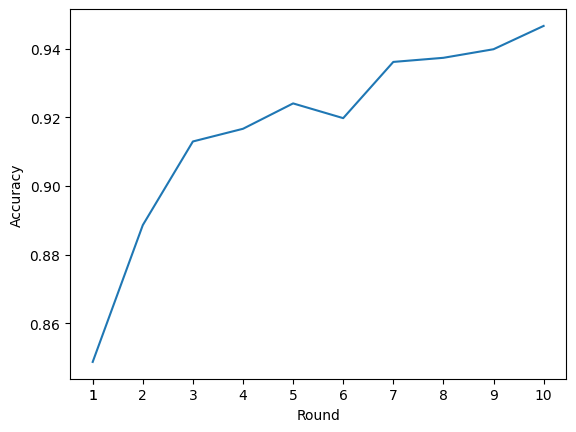

In [78]:
# Plot accuracy per round
NUM_TICKS = 11

ys = np.array(accuracy_per_round)
xs = 1+np.arange(ys.size)
ticks = (1+(ys.size-1)*np.arange(NUM_TICKS)/(NUM_TICKS-1)).astype(int)
plt.plot(xs, ys)
plt.gca().set_xticks(ticks)
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.show()